# Chater 1 Appendix: Potential outcome model

ここではLalonde DatasetにPotential outcome modelをfitさせ分析する。

### Package Install

In [1]:
pass

### Import

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

### Set seed

In [3]:
np.random.seed(123) 

### Read data

In [4]:
df = pd.read_csv('./data/nswre74.csv')
df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1369.0
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,484.0
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,900.0
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,729.0
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,1089.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   treat    445 non-null    int64  
 1   age      445 non-null    int64  
 2   ed       445 non-null    int64  
 3   black    445 non-null    int64  
 4   hisp     445 non-null    int64  
 5   married  445 non-null    int64  
 6   nodeg    445 non-null    int64  
 7   re74     445 non-null    float64
 8   re75     445 non-null    float64
 9   re78     445 non-null    float64
 10  age2     445 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 38.4 KB


In [6]:
pd.options.display.precision = 2
df.describe()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
count,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00
mean,0.42,25.37,10.20,0.83,0.09,0.17,0.78,2102.27,1377.14,5300.76,693.98
std,0.49,7.10,1.79,0.37,0.28,0.37,0.41,5363.58,3150.96,6631.49,429.78
min,0.00,17.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,289.00
25%,0.00,20.00,9.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,400.00
50%,0.00,24.00,10.00,1.00,0.00,0.00,1.00,0.00,0.00,3701.81,576.00
75%,1.00,28.00,11.00,1.00,0.00,0.00,1.00,824.39,1220.84,8124.72,784.00
max,1.00,55.00,16.00,1.00,1.00,1.00,1.00,39570.68,25142.24,60307.93,3025.00


## 前処理とEDA

treatment effectをgivenとして、potential outcomeを作成


In [7]:
df['Y'] = df['re78']
df['Y_0'] = df.loc[df['treat'] == 0, 're78']
df['Y_1'] = df.loc[df['treat'] == 1, 're78']
df['D'] = 0
df.loc[df['treat'] == 1, 'D'] = 1

In [8]:
df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2,Y,Y_0,Y_1,D
0,1,37,11,1,0,1,1,0.0,0.0,9930.05,1369.0,9930.05,NaN,9930.05,1
1,1,22,9,0,1,0,1,0.0,0.0,3595.89,484.0,3595.89,NaN,3595.89,1
2,1,30,12,1,0,0,0,0.0,0.0,24909.45,900.0,24909.45,NaN,24909.45,1
3,1,27,11,1,0,0,1,0.0,0.0,7506.15,729.0,7506.15,NaN,7506.15,1
4,1,33,8,1,0,0,1,0.0,0.0,289.79,1089.0,289.79,NaN,289.79,1


### SUTVA

Rubin(2015)におけるSUTVAの定義は

```
The po定義ential outcomes for any unit do not vary with the treatments assigned to other units, and, for each unit there are no different forms or versions of each treatment level, which lead to different potential outcomes.
```

つまり

$$
(Y^0, Y^1) \perp D
$$


### Missing data imputation

Naiveな方法で実施すると

In [9]:
df_naive = df.copy()
df_naive.loc[df['D'] == 0, 'Y_1'] = df['Y_1'].mean()
df_naive.loc[df['D'] == 1, 'Y_0'] = df['Y_0'].mean()
print('Our estimated treatment effect is {:10.2f}'.format((df_naive['Y_1'] - df_naive['Y_0']).mean()))

Our estimated treatment effect is    1794.34


ただし、これはestimateのuncertaintyを考慮していないので、以下のように修正する

#### 方針

```
T1, T0 = calculate each number of units group by treatment status

Y_1_sampled, Y_1_sampled = sample poptential outcome observed from data in accrodance with T1, T0

imputeY_1_sampled, Y_1_sampled to the missing value of the data

compute the ATE
```



In [10]:
status_counts = df['D'].value_counts().to_dict()
status_counts

{0: 260, 1: 185}

In [11]:
### seed固定
np.random.seed(121212)

stats = list()
for _ in range(100):
    y_1_sampled = df['Y_1'].dropna().sample(n=status_counts[0], replace=True).values
    y_0_sampled = df['Y_0'].dropna().sample(n=status_counts[1], replace=True).values

    df_boot = df.copy()

    df_boot.loc[df_boot['D'] == 1, 'Y_0'] = y_0_sampled
    df_boot.loc[df_boot['D'] == 0, 'Y_1'] = y_1_sampled
    
    stat = (df_boot['Y_1'] - df_boot['Y_0']).mean()
    stats.append(stat)
print('Our estimated treatment effect is {:10.2f}'.format(np.mean(stats)))

Our estimated treatment effect is    1778.24


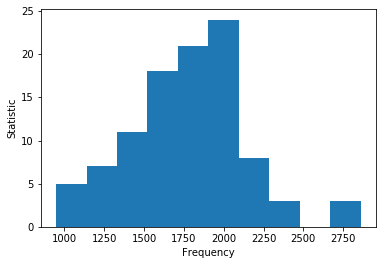

In [12]:
fig, ax = plt.subplots(1, 1)
ax.hist(stats)
ax.set_ylabel('Statistic')
ax.set_xlabel('Frequency');

## year of the fire horse

丙午の出生率に対するインパクトを記述統計レベルで分析する

### Assumption

$$
(Y^1_t, Y^0_t) \ \ i.i.d\sim D \text{ for all } t = 1, ..., T
$$

### Data

world bankより取得


In [13]:
df = pd.read_csv('./data/world_bank.csv', skiprows = 4)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,35.68,34.53,33.32,32.05,30.74,29.41,...,11.12,11.09,11.11,11.18,11.28,11.40,11.53,NaN,NaN,NaN
1,Afghanistan,AFG,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,51.28,51.37,51.46,51.53,51.59,51.63,...,38.75,37.69,36.67,35.71,34.81,33.98,33.21,NaN,NaN,NaN
2,Angola,AGO,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,49.08,48.78,48.55,48.43,48.45,48.62,...,45.10,44.49,43.85,43.18,42.52,41.88,41.28,NaN,NaN,NaN
3,Albania,ALB,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,40.92,40.37,39.63,38.72,37.70,36.60,...,12.10,12.20,12.26,12.26,12.20,12.08,11.93,NaN,NaN,NaN
4,Andorra,AND,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.50,NaN,NaN,NaN,8.80,NaN,NaN,NaN,NaN


In [14]:
df.set_index("Country Code", inplace=True)
df.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)

In [15]:
df_jp = df.loc["JPN", "1960":"2017"]
df_jp = df_jp.to_frame()
df_jp.index_name = "Year"
df_jp.columns = ['birth_rate']
df_jp.sort_index(inplace = True)
df_jp.index = df_jp.index.astype(int)
df_jp.head()

,birth_rate
1960,17
1961,17
1962,17
1963,17
1964,18


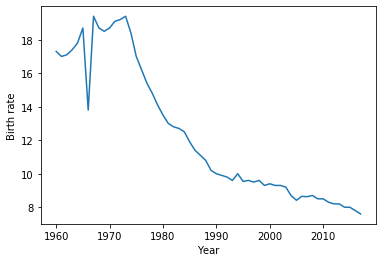

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(df_jp['birth_rate'].index, df_jp['birth_rate'])
ax.set_ylabel('Birth rate')
ax.set_xlabel('Year');

In [17]:
df_jp.loc[1960:1970, 'birth_rate']

1960    17
1961    17
1962    17
1963    17
1964    18
1965    19
1966    14
1967    19
1968    19
1969    18
1970    19
Name: birth_rate, dtype: object

In [18]:
y_0 = df_jp.loc[[1963, 1969], 'birth_rate'].mean()
y_1 = df_jp.loc[1966, 'birth_rate']
print(' A reasonable treatment effect is {:10.5f}'.format(y_1 - y_0))

 A reasonable treatment effect is   -4.15000
